In [1]:
# 
#GROUP 4 - SNELL FAMILY FARM
#Data questions:

#1) What is the pricing trend over the past couple of years?

#2) Has the pandemic impacted drug costs?

#3) Are some models more accurate at predicting drug cost than others?

#Methods of analysis:

#Time series: ARIMA (X), LSTM, exponential smoothing, ARCH GARCH, Prophet

#Other : Association Rule mining, Clustering, Decision tree, Word cloud

#Predictive Models : Naiive bayes , SVM



In [2]:
#IMPORT LIBRRARIES :import packages for analysis and modeling

import pandas as pd  # data frame operations
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt  # 2D plotting
from seaborn import palettes
%matplotlib inline

import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
import requests
import json


In [3]:
# OBTAIN: Pharmacy Data (potential 1 )

# New Market Drugs:
#-----------------
# Prescription Drugs introduced to the Market (https://data.chhs.ca.gov/dataset/prescription-drugs-introduced-to-market)
# The table represents new prescription drugs introduced to market in California with a Wholesale Acquisition Cost (WAC) that exceeds the Medicare Part D specialty drug cost threshold

dfNewRx2022 = pd.read_excel('https://data.chhs.ca.gov/dataset/e54d331c-65d3-4c6e-b4ba-390bd7024248/resource/eded767c-4651-46d6-8b40-d34db9560091/download/newdrugdata-mar2022.xlsx')
dfNewRx2021 = pd.read_excel('https://data.chhs.ca.gov/dataset/e54d331c-65d3-4c6e-b4ba-390bd7024248/resource/ba710f43-749d-4c6f-b105-28845cd742b7/download/ctrx-new-drug-report-2021-q1-q2-q3.xlsx')
dfNewRx2020 = pd.read_excel('https://data.chhs.ca.gov/dataset/e54d331c-65d3-4c6e-b4ba-390bd7024248/resource/9a37709e-4151-4300-a031-91ea7813da60/download/ctrx-new-drug-report-2020-q1-q2-q3-q4.xlsx')
dfNewRx2019 = pd.read_excel('https://data.chhs.ca.gov/dataset/e54d331c-65d3-4c6e-b4ba-390bd7024248/resource/6393cda0-6101-424e-b738-07aee9e6f94f/download/ctrx-new-drug-report-2019-q1-q2-q3-q4.xlsx')

# Medicare Part D Spending by Drug:
#------------------------------------
# Data dictionary: https://data.cms.gov/resources/medicare-part-d-spending-by-drug-data-dictionary
# import requests
# import json
medicareRx = requests.get('https://data.cms.gov/data-api/v1/dataset/54426646-2108-48e7-a339-730dcfabbe9a/data').json()
medicareRx=pd.json_normalize(medicareRx)
medicareRx.head()

# Medicaid :
#------------------------------------
#website location: https://data.cms.gov/summary-statistics-on-use-and-payments/medicare-medicaid-spending-by-drug/medicaid-spending-by-drug
# data dictionary: https://data.cms.gov/resources/medicaid-spending-by-drug-data-dictionary

medicaidRx = requests.get('https://data.cms.gov/data-api/v1/dataset/fa5241b2-a4f9-45e5-8d73-8a29424b6598/data').json()
medicaidRx=pd.json_normalize(medicaidRx)
medicaidRx.head()


,Brnd_Name,Gnrc_Name,Tot_Mftr,Mftr_Name,Tot_Spndng_2016,Tot_Dsg_Unts_2016,Tot_Clms_2016,Avg_Spnd_Per_Dsg_Unt_Wghtd_2016,Avg_Spnd_Per_Clm_2016,Outlier_Flag_2016,...,Avg_Spnd_Per_Clm_2019,Outlier_Flag_2019,Tot_Spndng_2020,Tot_Dsg_Unts_2020,Tot_Clms_2020,Avg_Spnd_Per_Dsg_Unt_Wghtd_2020,Avg_Spnd_Per_Clm_2020,Outlier_Flag_2020,Chg_Avg_Spnd_Per_Dsg_Unt_19_20,CAGR_Avg_Spnd_Per_Dsg_Unt_16_20
0,8hr Arthritis Pain,Acetaminophen,1,Overall,,,,,,,...,5.054640884,1,433.73,4600,49,0.0942891304,8.8516326531,1,0.5170523232,0.5170523232
1,8hr Arthritis Pain,Acetaminophen,1,Topco,,,,,,,...,5.054640884,1,433.73,4600,49,0.0942891304,8.8516326531,1,0.5170523232,0.5170523232
2,A & D,Vitamins A And D,1,Overall,470.91,7992.4,49,0.0589197237,9.6104081633,1,...,6.3661983471,1,322.51,15751.8,41,0.0204744855,7.866097561,1,1.1920761057,-0.232217739
3,A & D,Vitamins A And D,1,Schering-Plough,470.91,7992.4,49,0.0589197237,9.6104081633,1,...,6.3661983471,1,322.51,15751.8,41,0.0204744855,7.866097561,1,0.3644461734,-0.232217739
4,A And D,Vits A And D/White Pet/Lanolin,1,Overall,,,,,,,...,4.6682352941,1,138.49,1483.5,19,0.0933535558,7.2889473684,1,0.2963157569,-0.069870597


In [4]:
# Time Series
# New Drug Introduced into the Market Data Set:

In [5]:
#SCRUB - New Drug Dataset

#consolidate columns
newMktRx =[dfNewRx2022,dfNewRx2021,dfNewRx2020,dfNewRx2019]
newMktRx=pd.concat(newMktRx)
#print(newMktRx.info())

#rename column
newMktRx.rename(columns = {'Manufacturer Name':'Manufacturer',\
                           'NDC Number':'NDC',\
                           'Drug Product Description':'ProdDesc',\
                           'Date Introduced to Market':'Date',\
                           'WAC at Introduction':'WAC',\
                           'Marketing/Pricing Plan Description':'PlanDesc',\
                           'Estimated Number of Patients':'EstNoPat',\
                           'Breakthrough Therapy Indicator':'TherapyFlag',\
                           'Marketing/Pricing Plan Non-Public Indicator':'PlanFlag',\
                           'Priority Review Indicator':'ReviewFlag'},inplace=True)

#set NDC as string instead of numeric
newMktRx.NDC = newMktRx.NDC.astype(str)

# drop unecessary columns
newMktRx = newMktRx.drop(['Acquisition Date','Acquisition Price','Acquisition Price Non-Public Indicator',\
                          'Acquisition Price Comment','General Comments','Supporting Documents',\
                          'Unnamed: 16','Unnamed: 17','Unnamed: 18',\
                          'Unnamed: 19','Unnamed: 20','Unnamed: 21',\
                          'Unnamed: 22','Unnamed: 23','Unnamed: 24',\
                          'Unnamed: 25','Unnamed: 26','Unnamed: 27',\
                          'Unnamed: 28','Unnamed: 29'],axis=1)
newMktRx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 0 to 314
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Manufacturer  974 non-null    object 
 1   NDC           974 non-null    object 
 2   ProdDesc      973 non-null    object 
 3   Date          974 non-null    object 
 4   WAC           974 non-null    float64
 5   PlanDesc      466 non-null    object 
 6   PlanFlag      509 non-null    object 
 7   EstNoPat      773 non-null    object 
 8   TherapyFlag   149 non-null    object 
 9   ReviewFlag    232 non-null    float64
dtypes: float64(2), object(8)
memory usage: 83.7+ KB


In [6]:
#SCRUB - Determine % of missing data

# Checking for missing data:

print('New Drug Missing Data:\n')
for col in newMktRx.columns:
    pct_missing = np.mean(newMktRx[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

# Plan Description, Plan Flag, Breakthrough Therapy Flag and Review Flag have more than 50% missing values 
# Estimated Number of Patients have approximately 22% missing data

New Drug Missing Data:

Manufacturer - 0%
NDC - 0%
ProdDesc - 0%
Date - 0%
WAC - 0%
PlanDesc - 52%
PlanFlag - 48%
EstNoPat - 21%
TherapyFlag - 85%
ReviewFlag - 76%


Teva Pharmaceuticals USA                  67
Amneal Pharmaceuticals                    45
SUN PHARMACEUTICALS                       36
Dr. Reddy's Laboratories, Inc.            33
PureTek Corporation                       27
                                          ..
Neurocrine Biosciences, Inc.               1
Myovant Sciences Inc.                      1
Mitsubishi Tanabe Pharma America, Inc.     1
Mirum Pharmaceuticals                      1
Coherus BioSciences, Inc.                  1
Name: Manufacturer, Length: 199, dtype: int64


C:\Users\nickl\AppData\Roaming\Python\Python39\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


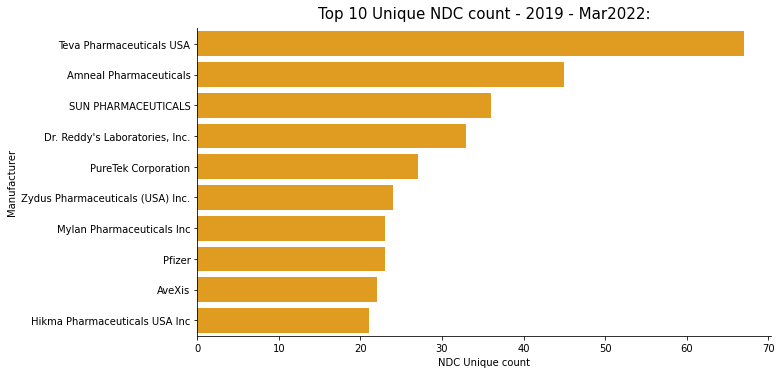

In [7]:
# EXPLORE:

#count unique NDC code by Manufacturing company:
print(pd.value_counts(newMktRx['Manufacturer']))
df=newMktRx.groupby('Manufacturer')['NDC'].nunique()
df=pd.DataFrame(df)
#df.describe(include='all')

#top 10:
df['Manufacturer'] = df.index
toprx=df.nlargest(10,'NDC')  #explore manufaturing company with highest NDC count

#graph:
g= sns.factorplot(x='NDC', y='Manufacturer',  kind='bar',color='orange',data=toprx)
g.fig.set_size_inches(20,5)
plt.title('Top 10 Unique NDC count - 2019 - Mar2022:',pad=10, fontsize=15)
g.set_xlabels('NDC Unique count')
g.set_ylabels('Manufacturer')


In [8]:
rx = newMktRx
rx = rx.set_index('Date')
rx.index = pd.to_datetime(rx.index) #set index to datetime
rx=rx.drop(['ProdDesc','PlanDesc','PlanFlag','EstNoPat','TherapyFlag','ReviewFlag'],axis=1)
rx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 974 entries, 2022-02-22 to 2019-10-15
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Manufacturer  974 non-null    object 
 1   NDC           974 non-null    object 
 2   WAC           974 non-null    float64
dtypes: float64(1), object(2)
memory usage: 30.4+ KB


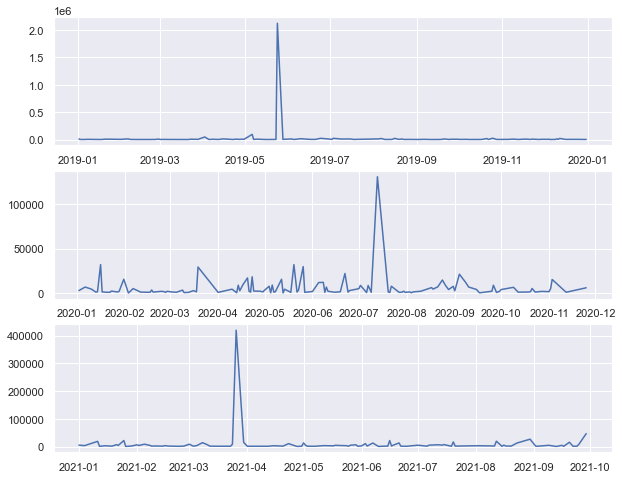

Empty DataFrame
Columns: []
Index: []


In [9]:
# EXPLORE - Looking at RX introduction across the years

#set model to be NDC count or WAC median
rxc=rx.groupby('Date')['NDC'].nunique()
rxm=rx.groupby('Date')['WAC'].median()

#set graph model 
rx1 = rxm
rx1=pd.DataFrame(rx1)

sns.set(rc={'figure.figsize':(10,8)})
groups = rx1['2019':'2021'].groupby(pd.Grouper(freq=('A')))
years = pd.DataFrame()
plt.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
	plt.subplot((n_groups*100) + 10 + i)
	i += 1
	plt.plot(group)
plt.show()
print(years)
print(groups)

Text(0.5, 1.0, 'WAC of Manufacturers Over Time')

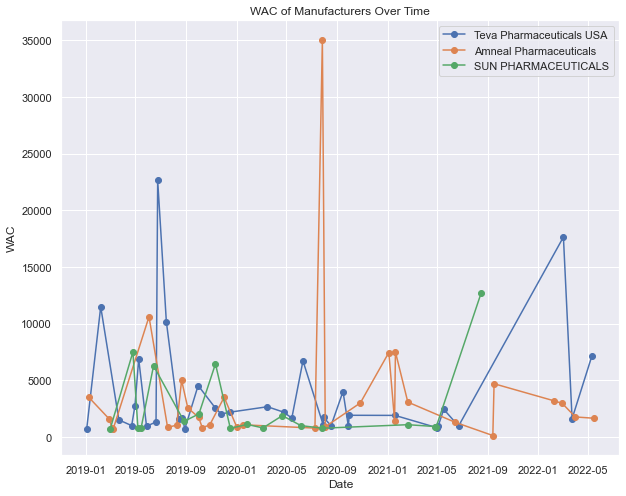

In [10]:
wac_by_manufacturer=rx.groupby(['Date', 'Manufacturer'])['WAC'].median().reset_index()
wac_by_manufacturer = wac_by_manufacturer.pivot(index="Date", columns="Manufacturer", values="WAC")

for manufacturer in ['Teva Pharmaceuticals USA', 'Amneal Pharmaceuticals', 'SUN PHARMACEUTICALS' ]:
  plt.plot(wac_by_manufacturer[manufacturer].dropna(), linestyle='-',marker='o')

plt.xlabel("Date")
plt.ylabel("WAC")
plt.legend(['Teva Pharmaceuticals USA', 'Amneal Pharmaceuticals', 'SUN PHARMACEUTICALS' ])
plt.title("WAC of Manufacturers Over Time")

In [11]:
# EXPLORE - ADF
# IS OUR TIME SERIES STATIONARY OR NOT?

result = adfuller(rxc, autolag='AIC')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.419949
p-value: 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


In [12]:
rpx =pd.DataFrame(rx, columns=['Manufacturer','WAC', 'NDC'])
rpx['NDC'] = rpx['NDC'].astype(float) #convert string to numeric
print(rpx.dtypes)
print(rpx)

Manufacturer     object
WAC             float64
NDC             float64
dtype: object
                                 Manufacturer       WAC           NDC
Date                                                                 
2022-02-22              Aadi Bioscience, Inc.   6785.00  8.080302e+10
2022-01-24                             AbbVie   5671.26  7.423103e+07
2022-03-23                             AbbVie  10586.24  7.410433e+07
2022-04-05             Accord BioPharma, Inc.   3900.00  6.944800e+10
2022-03-23  Advanced Accelerator Applications  42500.00  6.694800e+10
...                                       ...       ...           ...
2019-09-16      Granules Pharmaceuticals Inc.    213.81  7.001000e+10
2019-09-19      Granules Pharmaceuticals Inc.    322.93  7.001000e+10
2019-05-16      Granules Pharmaceuticals Inc.     55.44  7.001000e+10
2019-05-16      Granules Pharmaceuticals Inc.     57.11  7.001000e+10
2019-10-15      Granules Pharmaceuticals Inc.    465.50  7.001000e+10

[97

In [13]:
#create train and test sets
from sklearn.model_selection import train_test_split

x1 = rpx[['WAC']]

y1 = rpx['Manufacturer']


X_train, X_test, y_train, y_test = train_test_split(
    x1, y1, test_size=0.25, random_state = 50)

#total rows in train sets
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)

X_train shape: (730, 1)
y_train shape: (730,)


In [14]:
print(X_train.dtypes)

WAC    float64
dtype: object


In [15]:
#total rows in test sets
print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

X_test shape: (244, 1)
y_test shape: (244,)


In [16]:
rpx.head() 

,Manufacturer,WAC,NDC
Date,,,
2022-02-22,"Aadi Bioscience, Inc.",6785.00,8.080302e+10
2022-01-24,AbbVie,5671.26,7.423103e+07
2022-03-23,AbbVie,10586.24,7.410433e+07
2022-04-05,"Accord BioPharma, Inc.",3900.00,6.944800e+10
2022-03-23,Advanced Accelerator Applications,42500.00,6.694800e+10


In [17]:
##create dataframe from data in X_train
#label the columns using the strings Manufacturer
rx_df = pd.DataFrame(X_train, columns=rpx.Manufacturer)

In [18]:
print(rx_df.dtypes)

Manufacturer
Aadi Bioscience, Inc.                float64
AbbVie                               float64
AbbVie                               float64
Accord BioPharma, Inc.               float64
Advanced Accelerator Applications    float64
                                      ...   
Granules Pharmaceuticals Inc.        float64
Granules Pharmaceuticals Inc.        float64
Granules Pharmaceuticals Inc.        float64
Granules Pharmaceuticals Inc.        float64
Granules Pharmaceuticals Inc.        float64
Length: 974, dtype: object


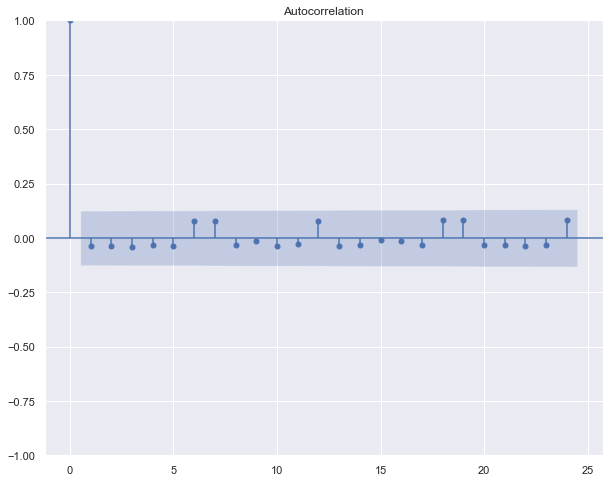

In [20]:
# creating ACF to determine ARCH model parameter
plot_acf(X_test)
plt.show()

# this shows positive correlation in variance to 10 lag time steps for the train set

In [36]:
# creating ARCH Model
from arch import arch_model

model = arch_model(X_train, mean = 'Zero', vol = 'ARCH', p = 10, rescale = 'TRUE')
model_fit = model.fit()

# forecast
forecasts = model_fit.forecast(horizon = 100, reindex = 'FALSE')

Iteration:      1,   Func. Count:     13,   Neg. LLF: 10212.800640172212
Iteration:      2,   Func. Count:     29,   Neg. LLF: 10198.165746206852
Iteration:      3,   Func. Count:     41,   Neg. LLF: 10198.149383659871
Iteration:      4,   Func. Count:     53,   Neg. LLF: 10198.145483229748
Iteration:      5,   Func. Count:     65,   Neg. LLF: 10197.800723700399
Iteration:      6,   Func. Count:     77,   Neg. LLF: 10197.805686368154
Iteration:      7,   Func. Count:     90,   Neg. LLF: 10211.967340130526
Iteration:      8,   Func. Count:    104,   Neg. LLF: 10197.747441801836
Iteration:      9,   Func. Count:    115,   Neg. LLF: 10197.747448014974
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10197.747441801836
            Iterations: 13
            Function evaluations: 115
            Gradient evaluations: 9


In [37]:
# Display Model Fitting Summary
print(model_fit.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                    WAC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -10197.7
Distribution:                  Normal   AIC:                           20417.5
Method:            Maximum Likelihood   BIC:                           20468.0
                                        No. Observations:                  730
Date:                Wed, Jun 15 2022   Df Residuals:                      730
Time:                        19:44:26   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.1876e+10  1.657e+10      4.337  1.445e-05 

In [38]:
# Creating the GARCH Model
Gmodel = arch_model(X_train, mean = 'Zero', vol = 'GARCH', p = 10, q = 10, rescale = 'TRUE', dist = 'normal')
Gmodel_fit = Gmodel.fit(update_freq = 4)

# forecast
Gforecasts = Gmodel_fit.forecast(horizon = 100, reindex = 'FALSE')

Iteration:      4,   Func. Count:     94,   Neg. LLF: 10291.923861505406
Iteration:      8,   Func. Count:    185,   Neg. LLF: 10160.947204154665
Iteration:     12,   Func. Count:    277,   Neg. LLF: 10200.271517943975
Iteration:     16,   Func. Count:    369,   Neg. LLF: 10138.360153821886
Iteration:     20,   Func. Count:    461,   Neg. LLF: 10144.086917353776
Iteration:     24,   Func. Count:    555,   Neg. LLF: 10518.834541839435
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10137.12267457643
            Iterations: 30
            Function evaluations: 611
            Gradient evaluations: 26


In [39]:
# Display Model Fitting Summary
print(Gmodel_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    WAC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -10137.1
Distribution:                  Normal   AIC:                           20316.2
Method:            Maximum Likelihood   BIC:                           20412.7
                                        No. Observations:                  730
Date:                Wed, Jun 15 2022   Df Residuals:                      730
Time:                        19:44:27   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      8.2076e+09  1.404e+10      0.584      0.559 

C:\Users\nickl\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


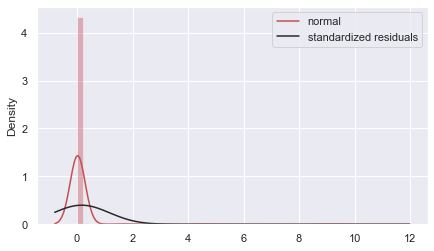

In [40]:
from scipy import stats
from scipy.stats import probplot, moment
# Obtain model estimated residuals and volatility
g_resid = Gmodel_fit.resid
g_std = Gmodel_fit.conditional_volatility

# Calculate the standardized residuals
g_std_resid = g_resid /g_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(g_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

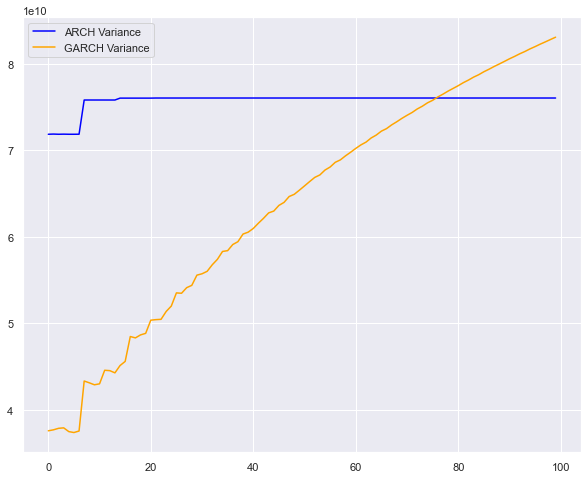

In [41]:
# plotting predicted variance of ARCH and GARCH Models
plt.plot(forecasts.variance.values[-1,:], color = 'blue', label = 'ARCH Variance')
plt.plot(Gforecasts.variance.values[-1,:], color = 'orange', label = 'GARCH Variance')
plt.legend()
plt.show()

In [ ]:
#create a KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
print("Test set predictions:", knn.predict(X_test))

In [ ]:
print("Test Accuracy: {:.2f}".format(knn.score(X_test, y_test)))

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np
import re

In [ ]:
#Heatmap
corr = rpx.corr()

corr.style.background_gradient(cmap='coolwarm')

In [ ]:
rpx_tp = rpx.nlargest(10, ['NDC'])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

values=rpx.values
# integer encode direction
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])
# ensure all data is float
values = values.astype('float64')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1) 
print(reframed.head())

In [ ]:
# split into train and test sets
values = reframed.values
n_train_days = 365 
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)